In [1]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

import jax

from pulsedjax.simulate_trace import MakeTrace, apply_noise, GaussianAmplitude, PolynomialPhase, MultiPulse, RandomPhase

/home/tillstehling/miniconda3/lib/python3.11/site-packages/refractiveindex/refractiveindex.py:300: RuntimeWarning: invalid value encountered in sqrt
  n = np.sqrt(nsq)


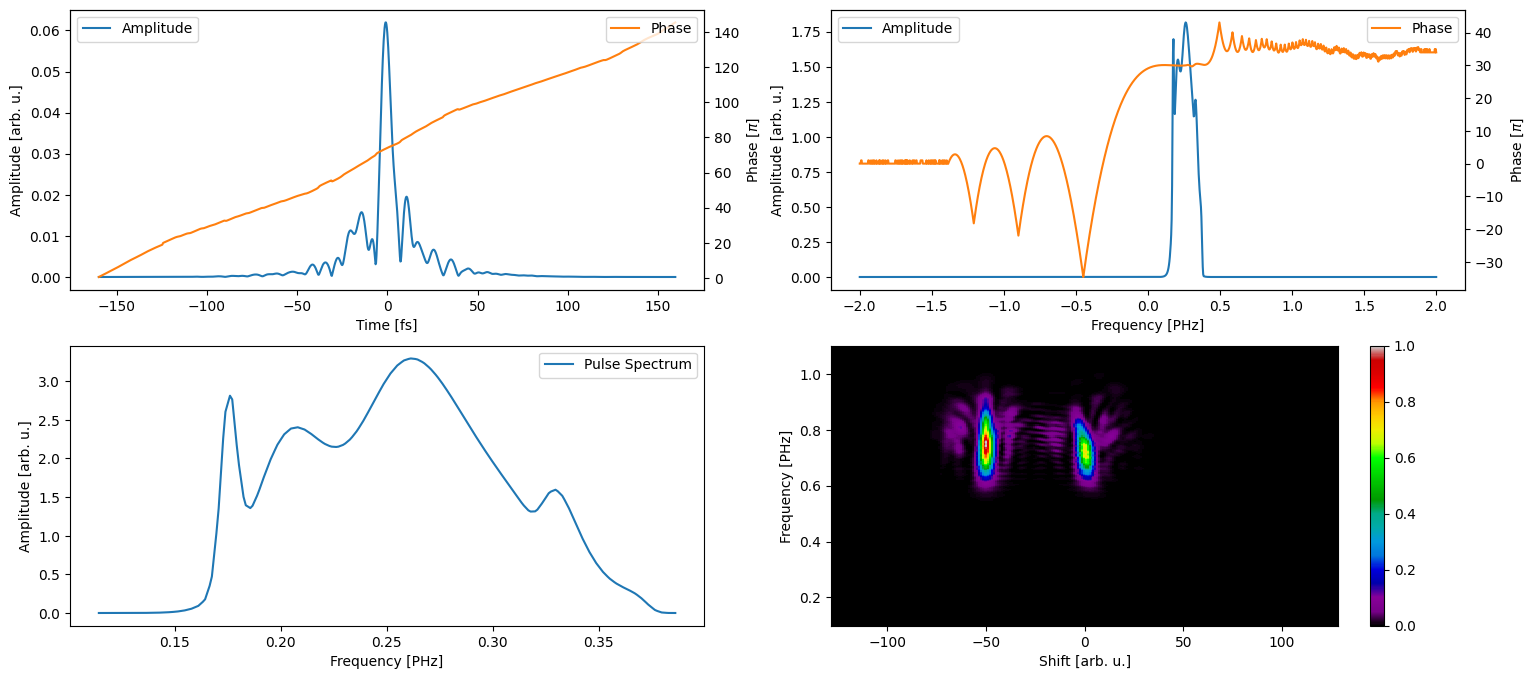

In [1]:
from pulsedjax.simulate_trace import MakeTrace
from pulsedjax.simulate_trace import GaussianAmplitude, RandomPhase
import jax.numpy as jnp

amp0 = GaussianAmplitude((1,1,1,0.9,0.5), (0.175,0.2,0.25,0.29,0.35), (0.01,0.05,0.1,0.1,0.05), (1,1,1,2,3))
phase0 = RandomPhase(number_of_points=4)


mp = MakeTrace(N=128*10, f_max=2)
time, pulse_t, frequency, pulse_f = mp.generate_pulse((amp0,phase0))


import refractiveindex
parameters = refractiveindex.RefractiveIndexMaterial(shelf="main", book="SiO2", page="Malitson")
delay = jnp.linspace(-100,100,128*2) 
delay, frequency_trace, trace, spectra = mp.generate_vampire(time, frequency, pulse_t, pulse_f, "thg", delay, 
                                                             tau_interferometer=50, material_thickness=1, frequency_range=(0.1,1.1), 
                                                             interpolate_fft_conform=True)


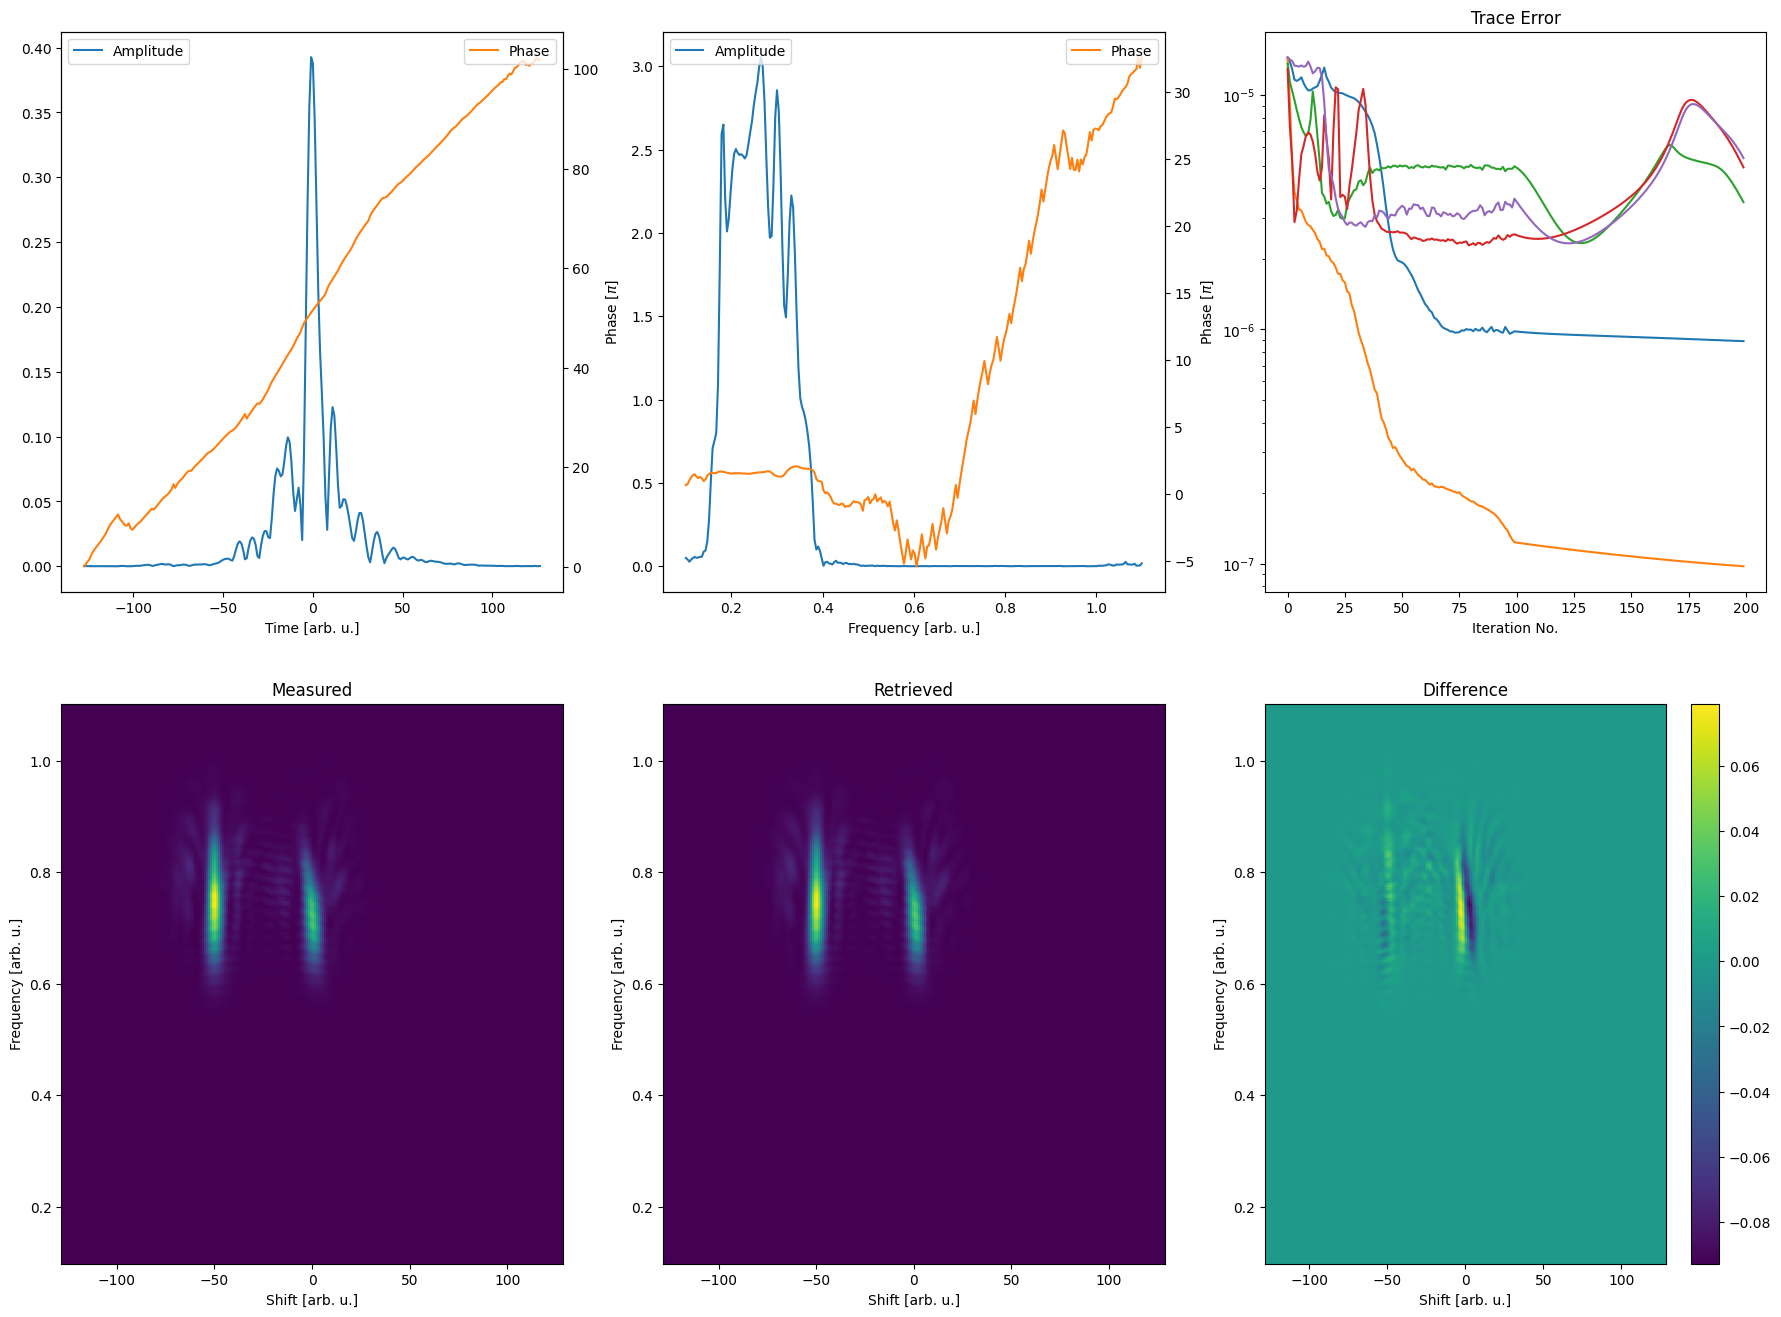

In [2]:
from pulsedjax.vampire import PtychographicIterativeEngine

copra = PtychographicIterativeEngine(delay, frequency_trace, trace, "thg", pie_method="rPIE", tau_interferometer=50, material_thickness=1.01)

population = copra.create_initial_population(5, "random")

copra.local_gamma = 0.1
copra.global_gamma = 0.01

final_result = copra.run(population, 100, 100)
copra.plot_results(final_result)